# Fit global epistasis models to functional scores for each selection to get mutation functional effects

Import Python modules.
We use `multidms` for the fitting:

In [1]:
import dms_variants.codonvarianttable

import matplotlib.pyplot as plt

import multidms

import pandas as pd

This notebook is parameterized by `papermill`.
The next cell is tagged as `parameters` to get the passed parameters.

In [2]:
# this cell is tagged parameters for `papermill` parameterization
selection = None
func_scores = None
func_effects = None
global_epistasis_params = None
threads = None

In [3]:
# Parameters
global_epistasis_params = {
    "clip_lower": "median_stop",
    "clip_upper": None,
    "collapse_identical_variants": False,
}
selection = "Both_B1T1-vs-B2T1"
func_scores = "results/func_scores/Both_B1T1-vs-B2T1_func_scores.csv"
func_effects = "results/func_effects/by_selection/Both_B1T1-vs-B2T1_func_effects.csv"
threads = 1


Read and clip functional scores:

In [4]:
func_scores_df = (
    pd.read_csv(func_scores, na_filter=None)
    .assign(condition=selection)
    .pipe(dms_variants.codonvarianttable.CodonVariantTable.classifyVariants)
)

median_stop = func_scores_df.query("variant_class == 'stop'")["func_score"].median()

for bound in ["upper", "lower"]:
    clip = global_epistasis_params[f"clip_{bound}"]
    if clip is None:
        print(f"No clipping on {bound} bound of functional scores")
    else:
        if clip == "median_stop":
            if pd.isnull(median_stop):
                raise ValueError(f"{median_stop=}")
            clip = median_stop
        assert isinstance(clip, (int, float)), clip
        print(f"Clipping {bound} bound of functional scores to {clip}")
        func_scores_df["func_score"] = func_scores_df["func_score"].clip(
            **{bound: clip}
        )

No clipping on upper bound of functional scores
Clipping lower bound of functional scores to -1.563


Initialize the data for `multidms`:

In [5]:
data = multidms.Data(
    variants_df=func_scores_df,
    reference=selection,
    alphabet=multidms.AAS_WITHSTOP_WITHGAP,
    collapse_identical_variants=global_epistasis_params["collapse_identical_variants"],
    letter_suffixed_sites=True,
    verbose=True,
    nb_workers=threads,
    assert_site_integrity=True,
)

inferring site map for Both_B1T1-vs-B2T1


  0%|          | 0/68496 [00:00<?, ?it/s]

Asserting site integrity


  0%|          | 0/68496 [00:00<?, ?it/s]

INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


unknown cond wildtype at sites: [],
dropping: 0 variantswhich have mutations at those sites.


invalid non-identical-sites: [], dropping 0 variants
Converting mutations for Both_B1T1-vs-B2T1
is reference, skipping


Now initialize the `multidms` model and fit it:

In [6]:
# initialize with default params, which give sigmoid global epistasis function
model = multidms.Model(data)

model.fit()

Look at accuracy of predictions and the global epistasis fit:

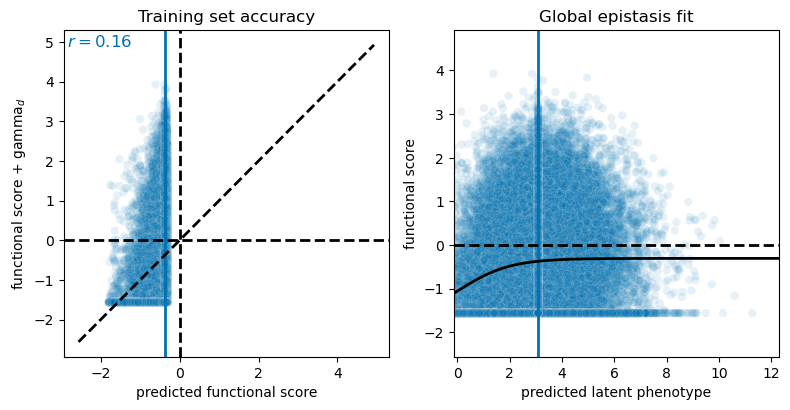

In [7]:
fig, ax = plt.subplots(1, 2, figsize=[8, 4])
model.plot_epistasis(ax=ax[1], alpha=0.1, show=False, legend=False)
model.plot_pred_accuracy(ax=ax[0], alpha=0.1, show=False, legend=False)
ax[1].set_title("Global epistasis fit")
ax[0].set_title("Training set accuracy")
plt.show()

Plot the distribution of latent phenotype functional scores with a few different cutoffs on `times_seen` (the number of variants in which a mutaiton is seen):

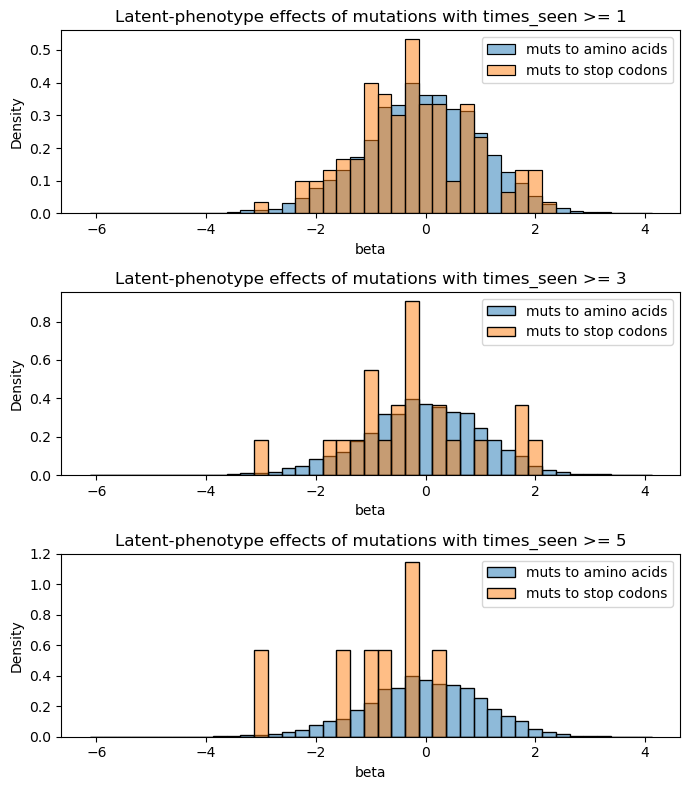

In [8]:
fig, axes = plt.subplots(3, 1, figsize=[7, 8])
for times_seen, ax in zip([1, 3, 5], axes):
    model.plot_param_hist("beta", ax=ax, show=False, times_seen_threshold=times_seen)
    ax.legend()
    ax.set_title(
        f"Latent-phenotype effects of mutations with times_seen >= {times_seen}"
    )
plt.tight_layout()
plt.show()

Get the effect of each mutation on the latent phenotype observed phenotype of the functional score (which we simply call the "functional effect" of the mutation):

In [9]:
mut_effects = (
    pd.concat(
        [
            # get mutant effects
            (
                model.get_mutations_df(phenotype_as_effect=True).rename(
                    columns={
                        f"times_seen_{selection}": "times_seen",
                        "wts": "wildtype",
                        "sites": "site",
                        "muts": "mutant",
                        f"{selection}_predicted_func_score": "functional_effect",
                        "beta": "latent_phenotype_effect",
                    }
                )
            ),
            # add wildtypes, which all have effects of 0
            pd.DataFrame(
                {
                    "site": data.site_map.index,
                    "wildtype": data.site_map[selection],
                    "mutant": data.site_map[selection],
                    "latent_phenotype_effect": 0,
                    "functional_effect": 0,
                }
            ),
        ],
    )
    .sort_values(["site", "mutant"])
    .reset_index(drop=True)
)

mut_effects

,wildtype,site,mutant,times_seen,latent_phenotype_effect,functional_effect
0,L,10,I,37.0,-0.975194,-0.096457
1,L,10,L,NaN,0.000000,0.000000
2,L,10,M,6.0,1.458751,0.049714
3,L,10,P,6.0,-2.229104,-0.381222
4,L,10,Q,3.0,0.724649,0.033017
...,...,...,...,...,...,...
8462,T,998,T,NaN,0.000000,0.000000
8463,G,999,C,6.0,0.598941,0.028777
8464,G,999,D,2.0,0.422212,0.021891
8465,G,999,G,NaN,0.000000,0.000000


Write the mutational effects to a file:

In [10]:
print(f"Writing the mutational effects to {func_effects}")

mut_effects.to_csv(func_effects, index=False, float_format="%.4g")

Writing the mutational effects to results/func_effects/by_selection/Both_B1T1-vs-B2T1_func_effects.csv
